In [3]:
!pip install pennylane matplotlib --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 128.6 MB/s eta 0:00:00


In [4]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [5]:
coeffs = [
    -0.04207897647782276,
    0.17771287465139946,
    0.17771287465139946,
    -0.24274280513140462,
    0.17059738328801055,
    -0.24274280513140462,
    0.17059738328801055,
    0.04475014401535161,
    -0.04475014401535161,
    -0.04475014401535161,
    0.04475014401535161,
    0.12293305056183801,
    0.16768319457718385,
    0.16768319457718385,
    0.12293305056183801
]

obs = [
    qml.Identity(0),
    qml.PauliZ(0),
    qml.PauliZ(1),
    qml.PauliZ(2),
    qml.PauliZ(3),
    qml.PauliZ(0) @ qml.PauliZ(1),
    qml.PauliZ(0) @ qml.PauliZ(2),
    qml.PauliZ(0) @ qml.PauliZ(3),
    qml.PauliZ(1) @ qml.PauliZ(2),
    qml.PauliZ(1) @ qml.PauliZ(3),
    qml.PauliZ(2) @ qml.PauliZ(3),
    qml.PauliY(0) @ qml.PauliX(1) @ qml.PauliX(2) @ qml.PauliY(3),
    qml.PauliY(0) @ qml.PauliY(1) @ qml.PauliX(2) @ qml.PauliX(3),
    qml.PauliX(0) @ qml.PauliX(1) @ qml.PauliY(2) @ qml.PauliY(3),
    qml.PauliX(0) @ qml.PauliY(1) @ qml.PauliY(2) @ qml.PauliX(3)
]

H = qml.Hamiltonian(coeffs, obs)

qubits = 4
n_electrons = 2

print(f"\n📊 Información del sistema:")
print(f"   Molécula: H2 (Hidrógeno)")
print(f"   Número de qubits: {qubits}")
print(f"   Número de electrones: {n_electrons}")
print(f"   Términos en el Hamiltoniano: {len(coeffs)}")
print(f"   Energía esperada del estado fundamental: ~-1.137 Ha")


📊 Información del sistema:
   Molécula: H2 (Hidrógeno)
   Número de qubits: 4
   Número de electrones: 2
   Términos en el Hamiltoniano: 15
   Energía esperada del estado fundamental: ~-1.137 Ha


In [6]:
dev = qml.device("default.qubit", wires=qubits)

# Estado Hartree-Fock: |1100⟩ (dos electrones en los primeros orbitales)
hf_state = np.array([1, 1, 0, 0])

print(f"\n🔬 Estado Hartree-Fock inicial: {hf_state}")
print("   Esto representa: dos electrones ocupando los dos primeros orbitales")

def ansatz_simple(params, wires):
    """Ansatz simple: preparación + 1 capa de rotaciones y CNOTs"""
    qml.BasisState(hf_state, wires=wires)

    # Una capa de rotaciones
    for i in range(qubits):
        qml.RY(params[i], wires=i)

    # Entrelazamiento en cadena
    for i in range(qubits - 1):
        qml.CNOT(wires=[i, i + 1])

def ansatz_medium(params, wires):
    """Ansatz medio: 2 capas de rotaciones y entrelazamiento"""
    qml.BasisState(hf_state, wires=wires)

    n_layers = 2
    for layer in range(n_layers):
        # Rotaciones
        for i in range(qubits):
            qml.RY(params[layer * qubits + i], wires=i)

        # Entrelazamiento
        for i in range(qubits - 1):
            qml.CNOT(wires=[i, i + 1])

def ansatz_deep(params, wires):
    """Ansatz profundo: 4 capas (puede sufrir de barren plateau)"""
    qml.BasisState(hf_state, wires=wires)

    n_layers = 4
    for layer in range(n_layers):
        for i in range(qubits):
            qml.RY(params[layer * qubits + i], wires=i)

        for i in range(qubits - 1):
            qml.CNOT(wires=[i, i + 1])



🔬 Estado Hartree-Fock inicial: [1 1 0 0]
   Esto representa: dos electrones ocupando los dos primeros orbitales


In [7]:
print("\n" + "=" * 70)
print("EXPERIMENTO 1: Comparando diferentes ansätze")
print("=" * 70)

# Diccionario de ansätze para probar
ansatze = {
    'Simple (1 capa)': (ansatz_simple, 4),
    'Medio (2 capas)': (ansatz_medium, 8),
    'Profundo (4 capas)': (ansatz_deep, 16)
}

results = {}

for name, (ansatz_func, n_params) in ansatze.items():
    print(f"\n🔧 Probando ansatz: {name}")
    print(f"   Número de parámetros: {n_params}")

    # Crear QNode con este ansatz
    @qml.qnode(dev)
    def cost_fn(params):
        ansatz_func(params, wires=range(qubits))
        return qml.expval(H)

    # Inicialización pequeña (recomendada)
    params_init = np.random.uniform(-0.1, 0.1, n_params, requires_grad=True)

    # Optimización con Adam
    opt = qml.AdamOptimizer(stepsize=0.1)
    params = params_init.copy()
    energy_history = []

    n_steps = 150
    for step in range(n_steps):
        params, energy = opt.step_and_cost(cost_fn, params)
        energy_history.append(energy)

        if step % 30 == 0:
            print(f"   Paso {step:3d}: E = {energy:.8f} Ha")

    results[name] = energy_history
    print(f"   ✅ Energía final: {energy_history[-1]:.8f} Ha")


EXPERIMENTO 1: Comparando diferentes ansätze

🔧 Probando ansatz: Simple (1 capa)
   Número de parámetros: 4
   Paso   0: E = -0.13166257 Ha
   Paso  30: E = -0.75897079 Ha
   Paso  60: E = -0.75627255 Ha
   Paso  90: E = -0.76063701 Ha
   Paso 120: E = -0.76080892 Ha
   ✅ Energía final: -0.76081413 Ha

🔧 Probando ansatz: Medio (2 capas)
   Número de parámetros: 8
   Paso   0: E = -0.38369880 Ha
   Paso  30: E = -1.20225784 Ha
   Paso  60: E = -1.22334647 Ha
   Paso  90: E = -1.22412188 Ha
   Paso 120: E = -1.22418406 Ha
   ✅ Energía final: -1.22418496 Ha

🔧 Probando ansatz: Profundo (4 capas)
   Número de parámetros: 16
   Paso   0: E = -0.79952284 Ha
   Paso  30: E = -1.22382195 Ha
   Paso  60: E = -1.22410188 Ha
   Paso  90: E = -1.22416370 Ha
   Paso 120: E = -1.22414461 Ha
   ✅ Energía final: -1.22418272 Ha


In [8]:
print("\n" + "=" * 70)
print("EXPERIMENTO 2: Efecto de la inicialización")
print("=" * 70)

@qml.qnode(dev)
def cost_medium(params):
    ansatz_medium(params, wires=range(qubits))
    return qml.expval(H)

initializations = {
    'Ceros': np.zeros(8, requires_grad=True),
    'Pequeños aleatorios': np.random.uniform(-0.1, 0.1, 8, requires_grad=True),
    'Grandes aleatorios': np.random.uniform(-np.pi, np.pi, 8, requires_grad=True),
    'Todos π/4': np.ones(8, requires_grad=True) * np.pi / 4
}

init_results = {}

for name, params_init in initializations.items():
    print(f"\n🎲 Inicialización: {name}")

    opt = qml.AdamOptimizer(stepsize=0.1)
    params = params_init.copy()
    energy_history = []

    for step in range(100):
        params, energy = opt.step_and_cost(cost_medium, params)
        energy_history.append(energy)

        if step % 25 == 0:
            print(f"   Paso {step:3d}: E = {energy:.8f} Ha")

    init_results[name] = energy_history
    print(f"   ✅ Energía final: {energy_history[-1]:.8f} Ha")



EXPERIMENTO 2: Efecto de la inicialización

🎲 Inicialización: Ceros
   Paso   0: E = -0.39750473 Ha
   Paso  25: E = -0.74532496 Ha
   Paso  50: E = -0.76081463 Ha
   Paso  75: E = -0.76070045 Ha
   ✅ Energía final: -0.76080643 Ha

🎲 Inicialización: Pequeños aleatorios
   Paso   0: E = -0.41424228 Ha
   Paso  25: E = -1.18940065 Ha
   Paso  50: E = -1.22124587 Ha
   Paso  75: E = -1.22392814 Ha
   ✅ Energía final: -1.22412212 Ha

🎲 Inicialización: Grandes aleatorios
   Paso   0: E = 0.08014749 Ha
   Paso  25: E = -1.19980706 Ha
   Paso  50: E = -1.21862313 Ha
   Paso  75: E = -1.22390014 Ha
   ✅ Energía final: -1.22414039 Ha

🎲 Inicialización: Todos π/4
   Paso   0: E = -0.54129887 Ha
   Paso  25: E = -1.21133525 Ha
   Paso  50: E = -1.22287283 Ha
   Paso  75: E = -1.22408178 Ha
   ✅ Energía final: -1.22417964 Ha


In [9]:
print("\n" + "=" * 70)
print("EXPERIMENTO 3: Efecto del learning rate")
print("=" * 70)

learning_rates = [0.01, 0.05, 0.1, 0.3, 0.5]
lr_results = {}

for lr in learning_rates:
    print(f"\n📊 Learning rate: {lr}")

    opt = qml.AdamOptimizer(stepsize=lr)
    params = np.random.uniform(-0.1, 0.1, 8, requires_grad=True)
    energy_history = []

    for step in range(100):
        params, energy = opt.step_and_cost(cost_medium, params)
        energy_history.append(energy)

        if step % 25 == 0:
            print(f"   Paso {step:3d}: E = {energy:.8f} Ha")

    lr_results[f"LR={lr}"] = energy_history
    print(f"   ✅ Energía final: {energy_history[-1]:.8f} Ha")


EXPERIMENTO 3: Efecto del learning rate

📊 Learning rate: 0.01
   Paso   0: E = -0.39109483 Ha
   Paso  25: E = -0.55080293 Ha
   Paso  50: E = -0.70086406 Ha
   Paso  75: E = -0.82168704 Ha
   ✅ Energía final: -0.97856538 Ha

📊 Learning rate: 0.05
   Paso   0: E = -0.42682338 Ha
   Paso  25: E = -0.88510291 Ha
   Paso  50: E = -1.21445214 Ha
   Paso  75: E = -1.22328209 Ha
   ✅ Energía final: -1.22411990 Ha

📊 Learning rate: 0.1
   Paso   0: E = -0.34488655 Ha
   Paso  25: E = -1.18720509 Ha
   Paso  50: E = -1.22063634 Ha
   Paso  75: E = -1.22384909 Ha
   ✅ Energía final: -1.22413047 Ha

📊 Learning rate: 0.3
   Paso   0: E = -0.38431120 Ha
   Paso  25: E = -1.21850966 Ha
   Paso  50: E = -1.22009827 Ha
   Paso  75: E = -1.22412788 Ha
   ✅ Energía final: -1.22417508 Ha

📊 Learning rate: 0.5
   Paso   0: E = -0.42859061 Ha
   Paso  25: E = -1.21024963 Ha
   Paso  50: E = -1.22186330 Ha
   Paso  75: E = -1.22404361 Ha
   ✅ Energía final: -1.22417649 Ha


In [10]:
print("\n" + "=" * 70)
print("ENERGÍA EXACTA (Diagonalización)")
print("=" * 70)

# Construir matriz del Hamiltoniano
H_matrix = qml.matrix(H, wire_order=range(qubits))
eigenvalues = np.linalg.eigvalsh(H_matrix)
exact_energy = eigenvalues[0]

print(f"\n🎯 Energía del estado fundamental (exacta): {exact_energy:.8f} Ha")


ENERGÍA EXACTA (Diagonalización)

🎯 Energía del estado fundamental (exacta): -1.22418510 Ha


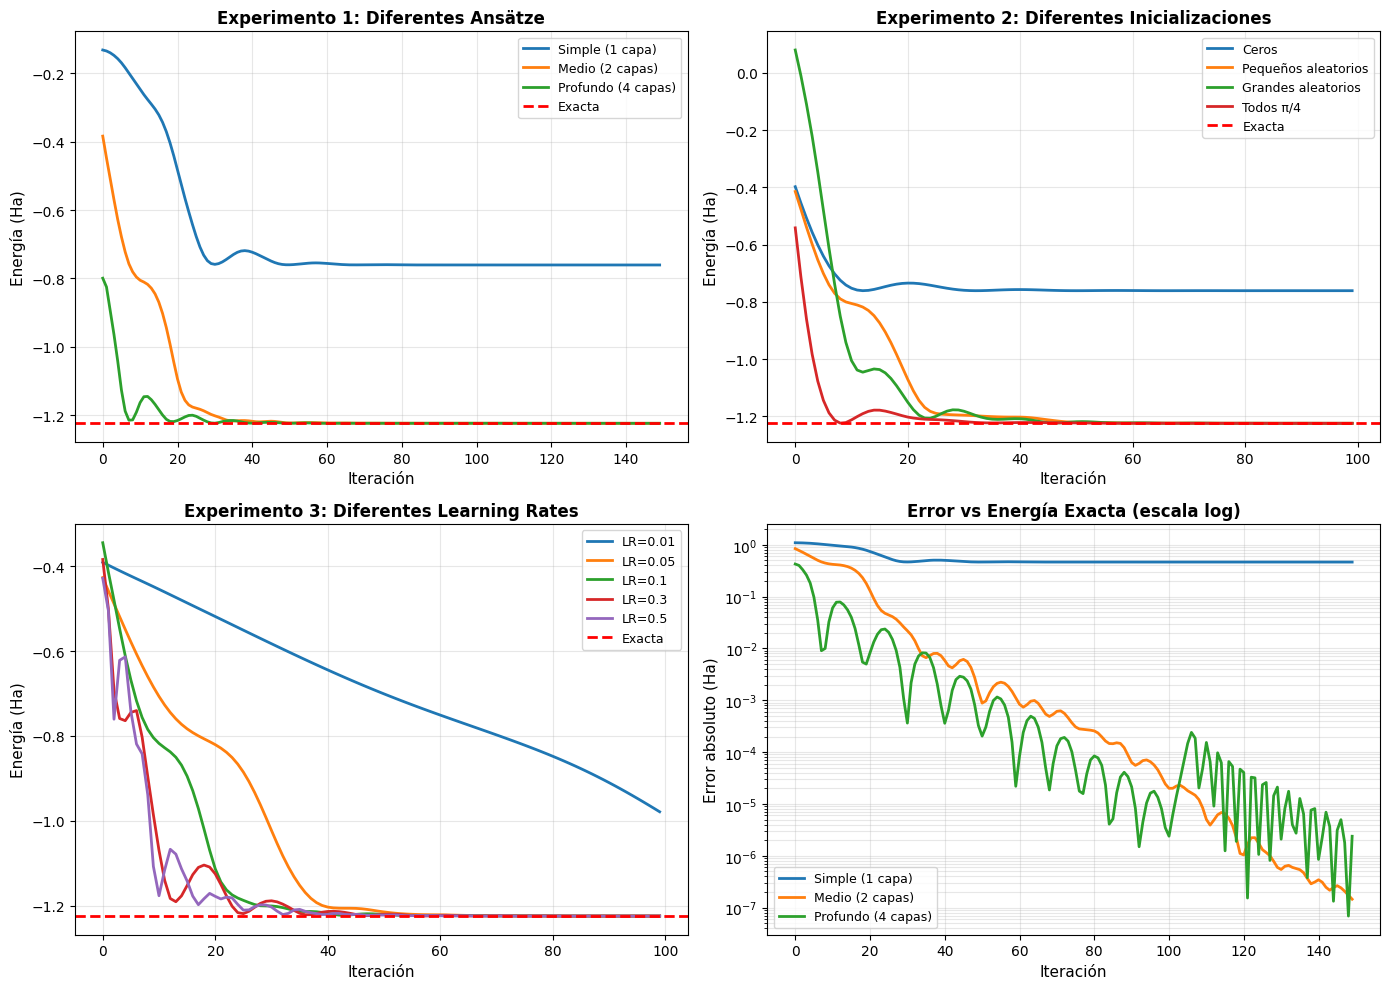

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Comparación de ansätze
ax1 = axes[0, 0]
for name, history in results.items():
    ax1.plot(history, label=name, linewidth=2)
ax1.axhline(y=exact_energy, color='red', linestyle='--', label='Exacta', linewidth=2)
ax1.set_xlabel('Iteración', fontsize=11)
ax1.set_ylabel('Energía (Ha)', fontsize=11)
ax1.set_title('Experimento 1: Diferentes Ansätze', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Gráfico 2: Inicializaciones
ax2 = axes[0, 1]
for name, history in init_results.items():
    ax2.plot(history, label=name, linewidth=2)
ax2.axhline(y=exact_energy, color='red', linestyle='--', label='Exacta', linewidth=2)
ax2.set_xlabel('Iteración', fontsize=11)
ax2.set_ylabel('Energía (Ha)', fontsize=11)
ax2.set_title('Experimento 2: Diferentes Inicializaciones', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Gráfico 3: Learning rates
ax3 = axes[1, 0]
for name, history in lr_results.items():
    ax3.plot(history, label=name, linewidth=2)
ax3.axhline(y=exact_energy, color='red', linestyle='--', label='Exacta', linewidth=2)
ax3.set_xlabel('Iteración', fontsize=11)
ax3.set_ylabel('Energía (Ha)', fontsize=11)
ax3.set_title('Experimento 3: Diferentes Learning Rates', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Gráfico 4: Errores en escala logarítmica
ax4 = axes[1, 1]
for name, history in results.items():
    errors = [abs(e - exact_energy) for e in history]
    ax4.semilogy(errors, label=name, linewidth=2)
ax4.set_xlabel('Iteración', fontsize=11)
ax4.set_ylabel('Error absoluto (Ha)', fontsize=11)
ax4.set_title('Error vs Energía Exacta (escala log)', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()


In [12]:
print("\n" + "=" * 70)
print("📊 RESUMEN DE RESULTADOS")
print("=" * 70)

print(f"\n🎯 Energía exacta: {exact_energy:.8f} Ha")
print(f"\nMejor resultado por experimento:")

print(f"\n1. Ansätze:")
for name, history in results.items():
    error = abs(history[-1] - exact_energy)
    print(f"   {name:20s}: E = {history[-1]:.8f} Ha, Error = {error:.6f} Ha")

print(f"\n2. Inicializaciones:")
for name, history in init_results.items():
    error = abs(history[-1] - exact_energy)
    print(f"   {name:20s}: E = {history[-1]:.8f} Ha, Error = {error:.6f} Ha")

print(f"\n3. Learning Rates:")
for name, history in lr_results.items():
    error = abs(history[-1] - exact_energy)
    print(f"   {name:20s}: E = {history[-1]:.8f} Ha, Error = {error:.6f} Ha")



📊 RESUMEN DE RESULTADOS

🎯 Energía exacta: -1.22418510 Ha

Mejor resultado por experimento:

1. Ansätze:
   Simple (1 capa)     : E = -0.76081413 Ha, Error = 0.463371 Ha
   Medio (2 capas)     : E = -1.22418496 Ha, Error = 0.000000 Ha
   Profundo (4 capas)  : E = -1.22418272 Ha, Error = 0.000002 Ha

2. Inicializaciones:
   Ceros               : E = -0.76080643 Ha, Error = 0.463379 Ha
   Pequeños aleatorios : E = -1.22412212 Ha, Error = 0.000063 Ha
   Grandes aleatorios  : E = -1.22414039 Ha, Error = 0.000045 Ha
   Todos π/4           : E = -1.22417964 Ha, Error = 0.000005 Ha

3. Learning Rates:
   LR=0.01             : E = -0.97856538 Ha, Error = 0.245620 Ha
   LR=0.05             : E = -1.22411990 Ha, Error = 0.000065 Ha
   LR=0.1              : E = -1.22413047 Ha, Error = 0.000055 Ha
   LR=0.3              : E = -1.22417508 Ha, Error = 0.000010 Ha
   LR=0.5              : E = -1.22417649 Ha, Error = 0.000009 Ha
